# DataCamp Certification Case Study

### Project Brief

You have been hired as a data scientist at a used car dealership in the UK. The sales team have been having problems with pricing used cars that arrive at the dealership and would like your help. Before they take any company wide action they would like you to work with the Toyota specialist to test your idea. They have already collected some data from other retailers on the price that a range of Toyota cars were listed at. It is known that cars that are more than £1500 above the estimated price will not sell. The sales team wants to know whether you can make predictions within this range.

The presentation of your findings should be targeted at the Head of Sales, who has no technical data science background.

The data you will use for this analysis can be accessed here: `"data/toyota.csv"`

In [131]:
# Use this cell to begin, and add as many cells as you need to complete your analysis!
# All libraries that will be used in this case stuy will be imported in this cell
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score # probably wont use all of them
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV # we will not use it
from sklearn.model_selection import GridSearchCV 

import xgboost as xgb

In [151]:
# All Functions that will be used in this case study will be written in this sell

def unique_classes(df):
    """takes in a dataframe, returns a dictionary containing classes of each categical column"""
    unique={}
    for col in df.columns:
        if df[col].dtype.name=='category':
            unique[col]=df[col].unique()      
    return unique

def freq_dist(df,col):
    """takes in a dataframe and a categorical column, returns a seaborn count plot of the column"""
    sns.set()
    fig,ax=plt.subplots(figsize=(15,6))
    ax=sns.countplot(x=col,
                  data= df,
             order=df[col].value_counts().index,palette=['blue'],alpha=0.7)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title(f'Distribution of {col} Feature',fontsize=18)
    
def draw_boxplots(df,col):
    """takes in a dataframe and a numerical column, return seaborn boxplot of the column"""
    fig,ax=plt.subplots( figsize=(10,5))
    ax=sns.boxplot(x=df[col], data=df, palette=['blue'])
    ax.set_title(f'Boxplots of {col} ', fontsize=18)

def draw_facetgrid_barchart(df,col1,row,col2):
    """takes in a datafram, categorical column, categoircal row, and numerical y-axis, return barcharts"""
    ax = sns.FacetGrid(df, col=col1, col_wrap=6)
    ax.map(sns.barplot,row,col2,palette=["blue"],alpha=0.6)
    ax.fig.suptitle(f'{col2} distribution of {col1} for each {row} category',y=1.03, fontsize=18)
    
def performance(y, y_predict):
    """ takein in expected y and predicted y and return Mean Square error, R^2, and Mean absolute error"""
    performance_dict={}
    performance_dict['R^2']=r2_score(y, y_predict)
    performance_dict["RMSE"]=mean_squared_error(y, y_predict)**0.5
    performance_dict["MAE"]=mean_absolute_error(y, y_predict)
    return performance_dict

def above_threshold(y,y_pred):
    """takes in two array, returns the count of diffeence above a  threshold"""
    return len([*filter( lambda x:x>1500,y_pred-y)])

In [3]:
# import data as a dataframe

df= pd.read_csv("data/toyota.csv")
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [4]:
# Check the datatype of eacch column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


In [5]:
# Let's see if there are any missing value
df.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

The data does not contain any missing values which is great. It looks like there are some columns that can be used a categorical variables. Also, the year column can be converted to age of the cars to better understand its impact on car price. We will create a new column 'age' and drop column' year'. We wil also check the classes in each categorical variable.

In [6]:
#Create a new feature 'age' and drop the 'year' feature
df['age']=2021-df.year
df.drop(columns='year', inplace=True)

In [7]:
# Convert the object datatype to category datatype
df['model']=df.model.astype('category')
df['transmission']=df.transmission.astype('category')
df['fuelType']=df.fuelType.astype('category')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   model         6738 non-null   category
 1   price         6738 non-null   int64   
 2   transmission  6738 non-null   category
 3   mileage       6738 non-null   int64   
 4   fuelType      6738 non-null   category
 5   tax           6738 non-null   int64   
 6   mpg           6738 non-null   float64 
 7   engineSize    6738 non-null   float64 
 8   age           6738 non-null   int64   
dtypes: category(3), float64(2), int64(4)
memory usage: 336.8 KB


In [9]:
# Find classes in each category 
unique_classes(df)

{'model': [' GT86', ' Corolla', ' RAV4', ' Yaris', ' Auris', ..., ' Supra', ' Camry', ' Verso-S', ' IQ', ' Urban Cruiser']
 Length: 18
 Categories (18, object): [' GT86', ' Corolla', ' RAV4', ' Yaris', ..., ' Camry', ' Verso-S', ' IQ', ' Urban Cruiser'],
 'transmission': ['Manual', 'Automatic', 'Semi-Auto', 'Other']
 Categories (4, object): ['Manual', 'Automatic', 'Semi-Auto', 'Other'],
 'fuelType': ['Petrol', 'Other', 'Hybrid', 'Diesel']
 Categories (4, object): ['Petrol', 'Other', 'Hybrid', 'Diesel']}

18 classes in a category seems too high. We will later check if we can reduce some classes in model column. Let us check some simple statistical parameters such as mean, standard deviaiton, range of both numerical and categorical columns.

In [10]:
df.describe(include='all')

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,age
count,6738,6738.000000,6738,6738.000000,6738,6738.000000,6738.000000,6738.000000,6738.000000
unique,18,NaN,4,NaN,4,NaN,NaN,NaN,NaN
top,Yaris,NaN,Manual,NaN,Petrol,NaN,NaN,NaN,NaN
freq,2122,NaN,3826,NaN,4087,NaN,NaN,NaN,NaN
mean,NaN,12522.391066,NaN,22857.413921,NaN,94.697240,63.042223,1.471297,4.251855
std,NaN,6345.017587,NaN,19125.464147,NaN,73.880776,15.836710,0.436159,2.204062
min,NaN,850.000000,NaN,2.000000,NaN,0.000000,2.800000,0.000000,1.000000
25%,NaN,8290.000000,NaN,9446.000000,NaN,0.000000,55.400000,1.000000,3.000000
50%,NaN,10795.000000,NaN,18513.000000,NaN,135.000000,62.800000,1.500000,4.000000
75%,NaN,14995.000000,NaN,31063.750000,NaN,145.000000,69.000000,1.800000,5.000000


The above table shows some useful information. For example:
- There are 6748 rows or observations in the data
- There are 18 different car models, and Yaris has the highest number of frequency
- There are four different types of  transmission. Interestingly, Manual transmission has the highest frequencey
- There are four different fuel type and Petrol is the mosly used fuel type which is not surprising.
- Average price of the car is about £12500 . That sounds quite high. Also, the lowest price of the car is only £850 and highest is about £60k which is pretty high for a used toyota car. However, 75% percentile of the price is below 15k. So, the maximum price of the car shown in the data could be an outlier or an error.
- The average age of the cars is only 4.25 years, with 75 percentile age is ony 5 years which suggest that 75% of the cars are not aged more than 5 year. The oldest age in the data set is 23 years old, the youngest age is only 1 year old.



 There are so many different way we can explore the dataset. Let's check aveage car price based on  categorical variable in the dataset.  This will not going to give us a lot of information on the price prediction as price will also depend on other factor such as age, and mileage. However, this will show some useful insight of the data based on the categorical variable.

In [11]:
#Create a pivot table that will show average car price of each model based on the transmission and fuelType used.
pivot_table=pd.pivot_table(df,values='price', index=['model','transmission'], columns='fuelType',aggfunc=np.mean, fill_value=0)
pivot_table

fuelType                           Diesel        Hybrid         Other  \
model          transmission                                             
 Auris         Automatic         0.000000  13821.915663  15495.000000   
               Manual         8460.833333      0.000000      0.000000   
               Semi-Auto         0.000000      0.000000      0.000000   
 Avensis       Automatic      4245.000000      0.000000      0.000000   
               Manual         9302.150685      0.000000      0.000000   
               Semi-Auto      7490.000000      0.000000      0.000000   
 Aygo          Automatic         0.000000      0.000000   9453.200000   
               Manual            0.000000      0.000000   7527.500000   
               Semi-Auto         0.000000      0.000000      0.000000   
 C-HR          Automatic         0.000000  21759.215909  26720.285714   
               Manual            0.000000      0.000000      0.000000   
 Camry         Automatic         0.000000  26910.090909      0.000000   
 Corolla       Automatic         0.000000  23146.038674  24245.000000   
               Manual         2495.000000      0.000000      0.000000   
 GT86          Automatic         0.000000      0.000000      0.000000   
               Manual            0.000000      0.000000      0.000000   
               Semi-Auto         0.000000      0.000000      0.000000   
 Hilux         Automatic     23296.523810      0.000000      0.000000   
               Manual        19794.113636      0.000000      0.000000   
 IQ            Automatic         0.000000      0.000000      0.000000   
               Manual            0.000000      0.000000      0.000000   
 Land Cruiser  Automatic     34319.000000      0.000000      0.000000   
               Manual        17328.333333      0.000000      0.000000   
               Semi-Auto     40302.259259      0.000000      0.000000   
 PROACE VERSO  Automatic     31291.888889      0.000000      0.000000   
               Manual        24762.666667      0.000000      0.000000   
 Prius         Automatic         0.000000  18866.200935  21359.705882   
               Manual            0.000000      0.000000   7250.000000   
 RAV4          Automatic     12228.956522  22947.121739  20848.800000   
               Manual        12530.923567      0.000000      0.000000   
               Semi-Auto         0.000000      0.000000      0.000000   
 Supra         Automatic         0.000000      0.000000  59995.000000   
               Semi-Auto         0.000000      0.000000      0.000000   
 Urban Cruiser Manual         4995.000000      0.000000      0.000000   
 Verso         Automatic         0.000000      0.000000  15750.000000   
               Manual        10522.862069      0.000000      0.000000   
               Semi-Auto         0.000000      0.000000      0.000000   
 Verso-S       Automatic         0.000000      0.000000      0.000000   
               Manual            0.000000      0.000000      0.000000   
 Yaris         Automatic         0.000000  12138.478261  11555.500000   
               Manual         6540.363636  13369.750000      0.000000   
               Other             0.000000  12795.000000      0.000000   
               Semi-Auto         0.000000      0.000000      0.000000   

fuelType                           Petrol  
model          transmission                
 Auris         Automatic     10626.500000  
               Manual         9467.680851  
               Semi-Auto      9492.000000  
 Avensis       Automatic     11654.375000  
               Manual        11184.727273  
               Semi-Auto      9130.000000  
 Aygo          Automatic      8491.464286  
               Manual         7710.274719  
               Semi-Auto      9263.095541  
 C-HR          Automatic     18365.428571  
               Manual        16506.023529  
 Camry         Automatic         0.000000  
 Corolla       Automatic      1547.000000  
               Manual        16644.419753  
 GT86     

The above table does not give entire picture of the dataset but it does give some useful information. For example:
- The average price of a automatic hybrid Yaris in the dataset is about 12k.

## Visualization
Let do some visualization to better undetands the data

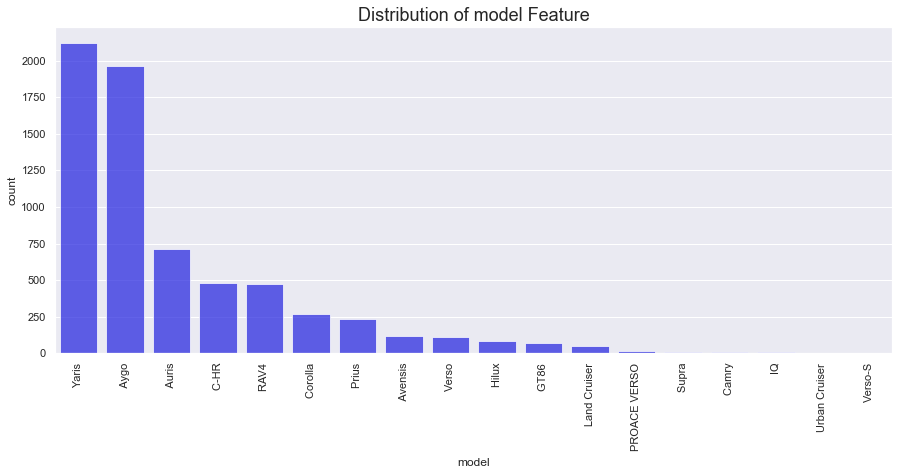

In [12]:
# Check the distribuiont of model column
freq_dist(df,'model')

In [20]:
#frequencies of model feature
df.model.value_counts()

 Yaris            2122
 Aygo             1961
 Auris             712
 C-HR              479
 RAV4              473
 Corolla           267
 Prius             232
 Avensis           115
 Verso             114
 Hilux              86
 GT86               73
 Land Cruiser       51
 PROACE VERSO       15
 Supra              12
 Camry              11
 IQ                  8
 Urban Cruiser       4
 Verso-S             3
Name: model, dtype: int64

It is clear from the above pricture that the first 10-12 classes are most important. The number of the cars belonging to the rest of models are very low. We can probably grouped them together as 'other'class in this category.

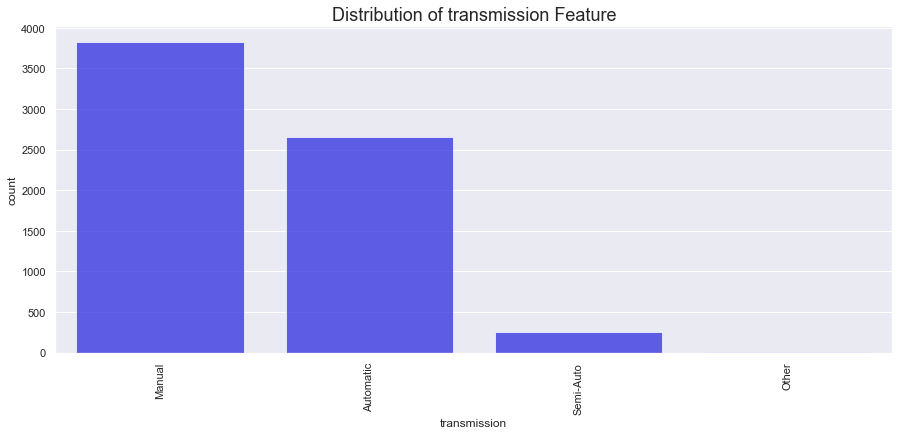

In [15]:
# Check the distribuiont of model column
freq_dist(df,'transmission')

In [16]:
#Frewuencies of transmission features
df.transmission.value_counts()

Manual       3826
Automatic    2657
Semi-Auto     254
Other           1
Name: transmission, dtype: int64

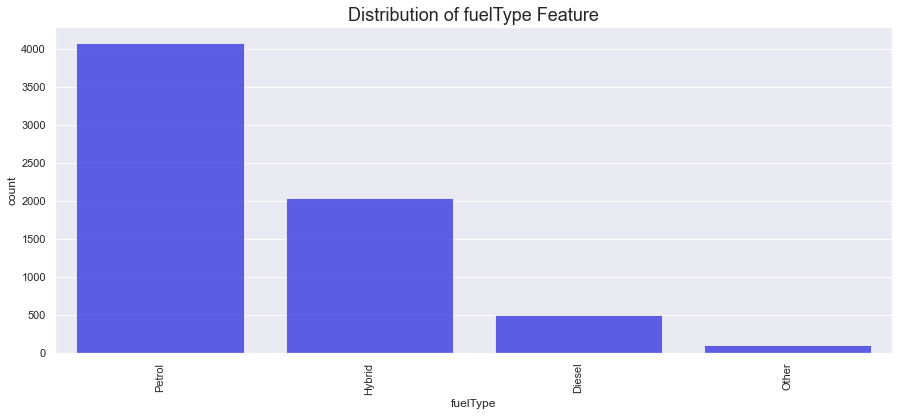

In [17]:
# Check the distribuiont of model column
freq_dist(df,'fuelType')

In [19]:
#frequencies of fuelType 
df.fuelType.value_counts()

Petrol    4087
Hybrid    2043
Diesel     503
Other      105
Name: fuelType, dtype: int64

Text(0.5, 1.05, 'Price distribution of transmission type for each fuel Type category')

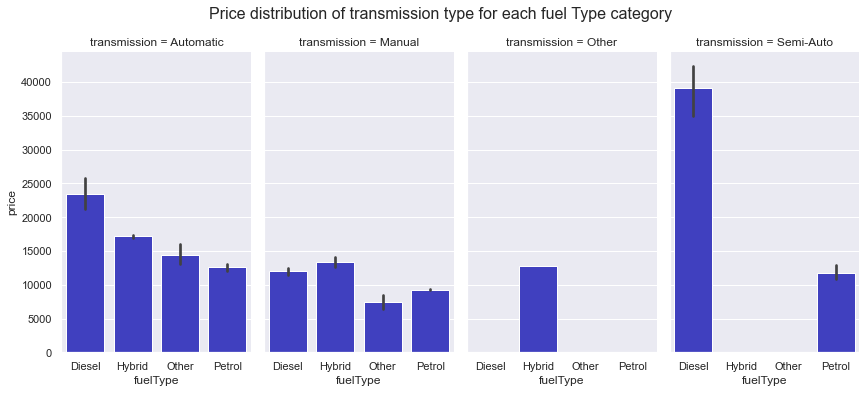

In [176]:
ax=sns.catplot(x="fuelType", y="price", col="transmission",
                data=df, saturation=.5,
                kind="bar", aspect=.6,palette=['blue'])
ax.fig.suptitle(f'Price distribution of transmission type for each fuel Type category',y=1.05, fontsize=16)

The above chart show that Diesel is the most expensive type in all category of transmission( except for othre category).

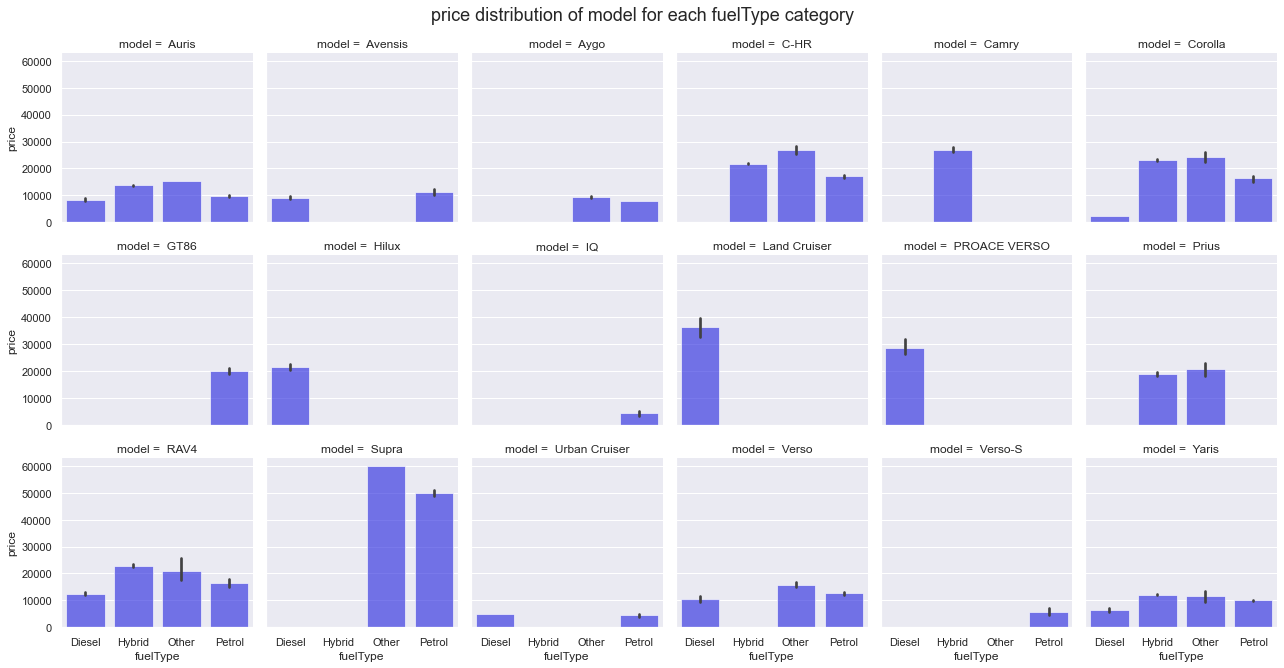

In [174]:
draw_facetgrid_barchart(df,'model','fuelType','price')

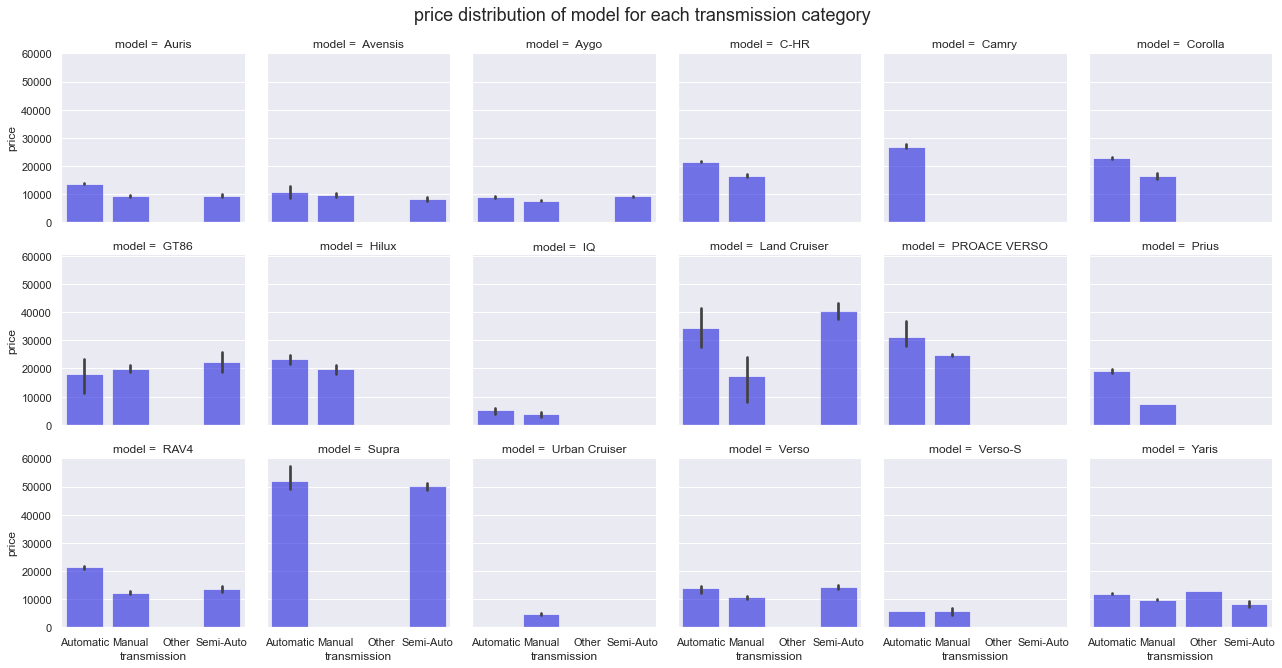

In [175]:
draw_facetgrid_barchart(df,'model','transmission','price')

The above two charts shows information such as:
- Model supra is the most expensive car in this used car data set.
- Automatic supra is more expensive than a semi-automatic one (withouth any statistical siginificance)


Now, lets explore the numerical columun.

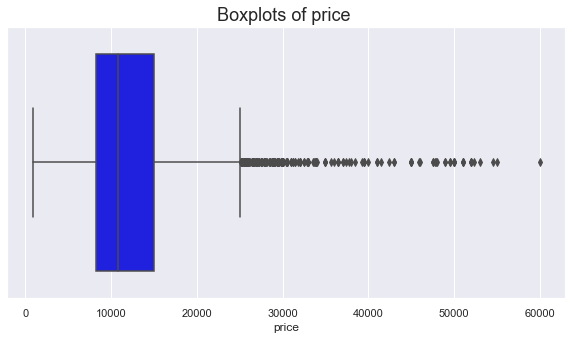

In [87]:

# Draw boxplots 
draw_boxplots(df,'price')

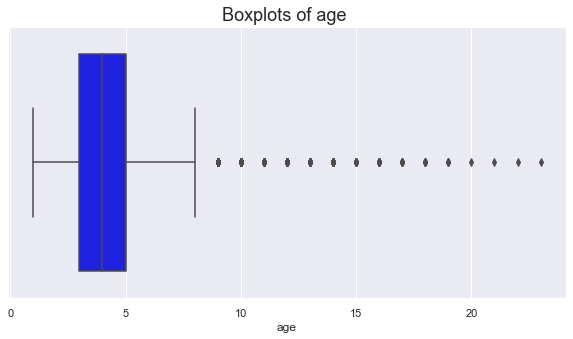

In [88]:
draw_boxplots(df,'age')

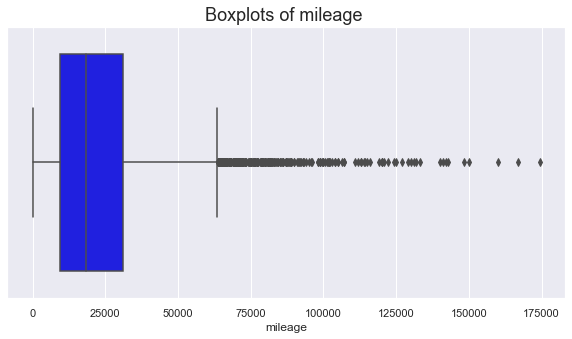

In [89]:
draw_boxplots(df,'mileage')

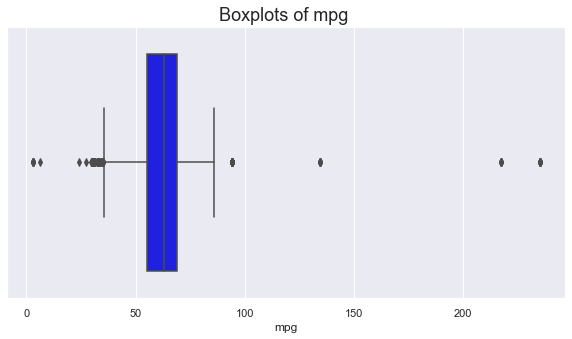

In [91]:
draw_boxplots(df,'mpg')

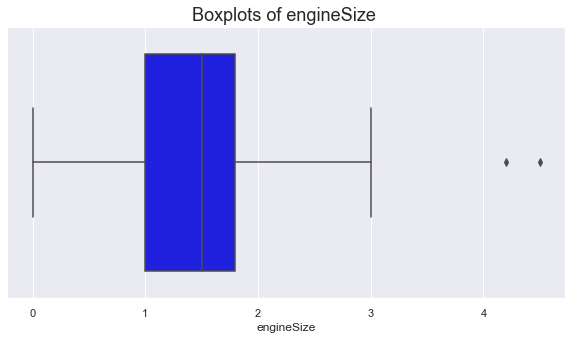

In [92]:
draw_boxplots(df,'engineSize')

It is aparent from the above boxplots that price, age, and mileage columns are not normally distributed and rightly skewed. To apply, any linear regressor model, we shoudl transform the data (such as usign a log transformation) so that we remove the skewness.

Now, let's see if there are ny correlation exist between the numerical data using a pairplot and correlation heatmap.

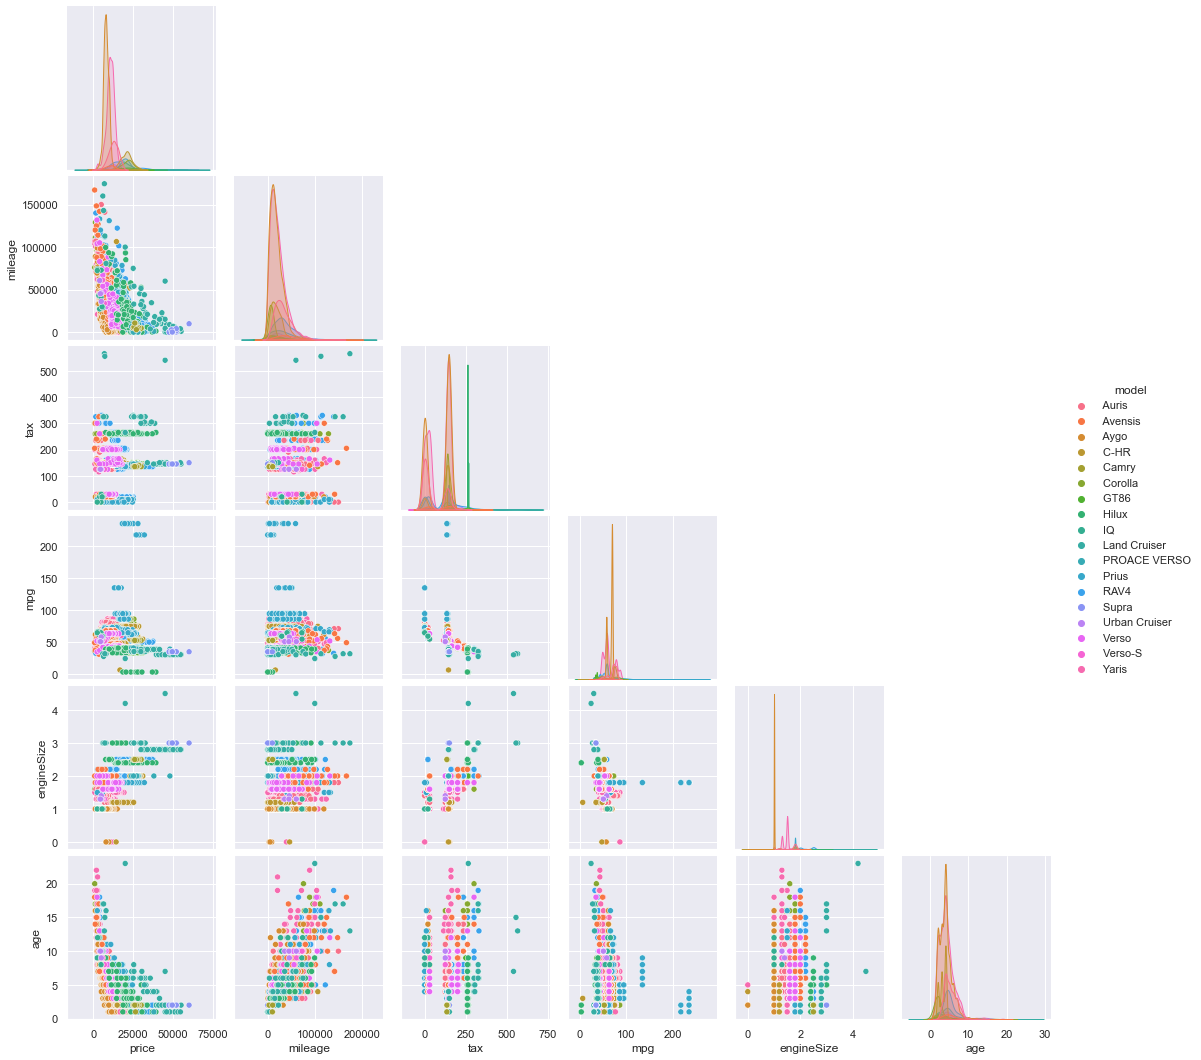

In [177]:
#pairplot
ax=sns.pairplot(df,hue='model',corner=True) # we do not need the upper righ of the plot

<AxesSubplot:>

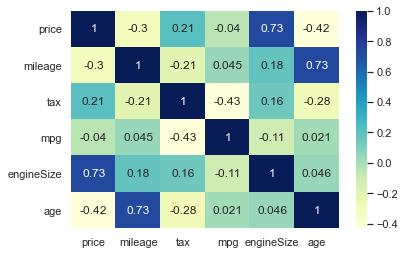

In [178]:
#correlation heatmap
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

The pairplot and the correlation plot show that there are not any unusual collinearlity between variables (excluding price). They also give us some important information, for example:
- price and mileage are inversely correlation
- price and age are inversely corelated
- price and engine size are postively correlated
- some relationship are hard to understand. So for those variable linear regrssion might not be a suitable options to predict price.
- heteroscedasticity might present between price and some variables-- (for example price and mileage)

# Model Development and Comparison
We will start with a simple linear regression model and then develop two additional models and check how they compare with each other based on some metrics

### Data Preparation
As we mentioned earlier some model classes can be caterized into 'other' class to reduce the number of low frequnecy classes. Howver, looking into the data we wee that there is a wide spread of price distribuiont among low frequncy classes. In addioon, the dealer might be intereested in pricing any low frequency model.Hence, we will first build and test our models with the as is' category and then if time permits we will rebuild our model with lower number of categories and check if there is any ipmorevement. 

First, We will convert categorial variables into 0-1 dummy variables to use categorical variables in our model. 

In [30]:
df_new=pd.get_dummies(df) 
df_new.head()

,price,mileage,tax,mpg,engineSize,age,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,...,model_ Verso-S,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,16000,24089,265,36.2,2.0,5,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,15995,18615,145,36.2,2.0,4,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,13998,27469,265,36.2,2.0,6,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,18998,14736,150,36.2,2.0,4,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,17498,36284,145,36.2,2.0,4,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [31]:
df_new.columns

Index(['price', 'mileage', 'tax', 'mpg', 'engineSize', 'age', 'model_ Auris',
       'model_ Avensis', 'model_ Aygo', 'model_ C-HR', 'model_ Camry',
       'model_ Corolla', 'model_ GT86', 'model_ Hilux', 'model_ IQ',
       'model_ Land Cruiser', 'model_ PROACE VERSO', 'model_ Prius',
       'model_ RAV4', 'model_ Supra', 'model_ Urban Cruiser', 'model_ Verso',
       'model_ Verso-S', 'model_ Yaris', 'transmission_Automatic',
       'transmission_Manual', 'transmission_Other', 'transmission_Semi-Auto',
       'fuelType_Diesel', 'fuelType_Hybrid', 'fuelType_Other',
       'fuelType_Petrol'],
      dtype='object')

In [32]:
# We need to drop som already explained categories
df_new.drop(['model_ Verso-S', 'transmission_Other', 'fuelType_Other'], axis=1, inplace=True)

In [69]:
#features of the model
features=df_new.drop('price',axis=1).columns
features

Index(['mileage', 'tax', 'mpg', 'engineSize', 'age', 'model_ Auris',
       'model_ Avensis', 'model_ Aygo', 'model_ C-HR', 'model_ Camry',
       'model_ Corolla', 'model_ GT86', 'model_ Hilux', 'model_ IQ',
       'model_ Land Cruiser', 'model_ PROACE VERSO', 'model_ Prius',
       'model_ RAV4', 'model_ Supra', 'model_ Urban Cruiser', 'model_ Verso',
       'model_ Yaris', 'transmission_Automatic', 'transmission_Manual',
       'transmission_Semi-Auto', 'fuelType_Diesel', 'fuelType_Hybrid',
       'fuelType_Petrol'],
      dtype='object')

#### Next, we will create featurs (X) and target (y) for predictive model

In [33]:
y = df_new["price"]
X = df_new.drop("price", axis = 1)
X = np.array(X)
y = np.array(y)

In [34]:
X.shape, y.shape

((6738, 28), (6738,))

#### Split the Data into training and testing sets

In [38]:
#20 percent for testing
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=1)
X_train.shape,y_train.shape

((5390, 28), (5390,))

In [105]:
X_test.shape,y_test.shape

((1348, 28), (1348,))

We will do a cross validation multiple linear regression on the training data. There are 5390 rows in train data. we will chose CV=5 so that each fold has 5390/5=1078 samples. cross_val_score produces R^2 

In [40]:
lr=LinearRegression()
cv_results=cross_val_score(lr, X_train,y_train, cv=5)
cv_results

array([0.93191448, 0.92305404, 0.92330198, 0.92302535, 0.92414162])

All the cross validation scores are quite good, above 0.92. We can say that linear regression could be a good model for the data. However, we can not only rely on R^2 value for regression problem. We need to check error related metrics,# We will now fit linear regression on the entire train data and predict witht he test data.
lr.fit(X_train,y_train) but before that let's use our model
to predict the test data


In [46]:
# We will now fit linear regression on the entire train data and predict witht he test data.
lr.fit(X_train,y_train)

LinearRegression()

In [47]:
y_pred_lr=lr.predict(X_test)

In [152]:
perf_lr=performance(y_test,y_pred_lr)
perf_lr

{'R^2': 0.9303060512955937,
 'RMSE': 1628.7493669790358,
 'MAE': 1069.1768216219293}

Let's also check out coefficients in our Linear Regression Model

In [68]:
lr_coeff=lr.coef_
lr_coeff

array([-6.13947068e-02, -4.00199855e+00, -7.84494832e+00,  2.99674313e+03,
       -8.16547406e+02, -6.99727993e+02,  5.10554037e+02, -3.46404760e+03,
        4.73959451e+03,  6.15440010e+03,  4.15044565e+03,  5.48286525e+03,
        7.29933459e+03, -9.46481596e+02,  2.21395929e+04,  1.31815849e+04,
        4.25626606e+03,  4.16045788e+03,  2.97176450e+04, -5.85578037e+02,
        5.03180133e+02, -2.32769000e+03, -9.76261472e+02, -2.34021763e+03,
       -9.54399849e+02, -2.64443197e+03,  3.08450566e+02, -1.15672732e+03])

We can plot the coefficients to see if there are some coefficeiint that are close to = 0. May be in the next modeling iteration we can build a model without them. 

Text(0.11, 0.3, 'zero Line')

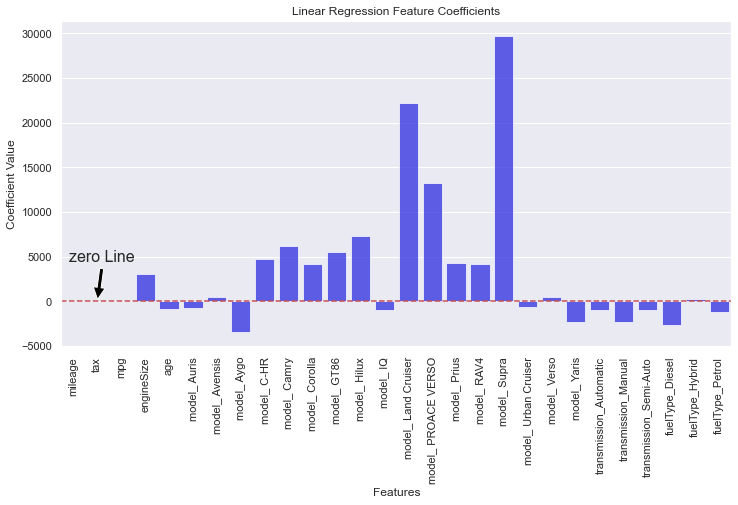

In [71]:
sns.set()
ax=plt.figure(figsize=(12,6))
ax=sns.barplot(x=features,y=lr_coeff,palette=['blue'],alpha=0.7)
ax.set(title = "Linear Regression Feature Coefficients", xlabel = "Features", ylabel = "Coefficient Value")
ax.set_xticklabels(features,rotation=90)
plt.axhline(y=0.0, color='r', linestyle='--')
ax.annotate('zero Line', (1, 0),
            xytext=(0.11, 0.3), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=16,
            horizontalalignment='right', verticalalignment='top')

It is shown in the above plot that some feature coefficient are indeed zero. In addition, the numerical sign in the coefficients match with what we saw in the pairplot and correlation plot.

Text(0.11, 0.3, '45 ° line')

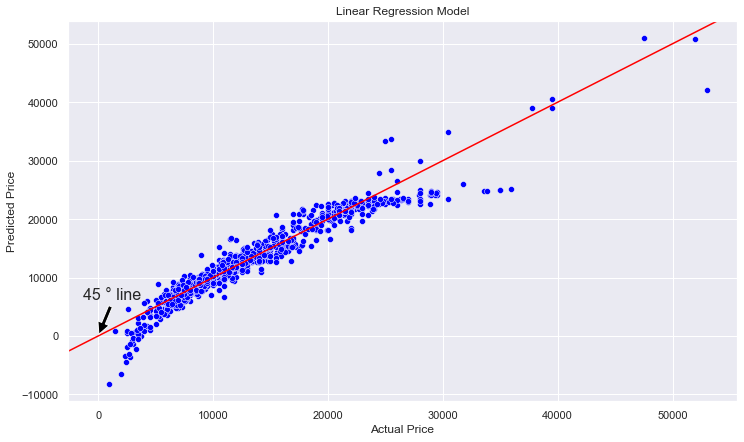

In [84]:
# need to write a function. but I do not have time
ax, fig= plt.subplots(figsize=(12,7))
ax = sns.scatterplot(y_test, y_pred_lr, color = 'blue')
ax.set(title = "Linear Regression Model", xlabel = "Actual Price", ylabel = "Predicted Price")
ax.axline([0, 0], [1, 1], color='red')
ax.annotate('45 \N{DEGREE SIGN} line', (1, 0),
            xytext=(0.11, 0.3), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=16,
            horizontalalignment='right', verticalalignment='top')

It looks like even with keeping the outlier the multiple linear regression model was quite good at prdiction  when price is between £5000 and £25,000.

Now let's check if the predicted price is more £1500 above the actual price.

In [147]:
z_lr= above_threshold(y_test,y_pred_lr)
z_lr

121

Thera are 121 test data poin that are above higher than £1500. However, the percentage is only =121/1348 = 8.9%

### Random Forest 
#### with Grid Search
Random Forest has a number of hyperparameters unlinke the linear regression withought regularization. We will use GridSearchCV technique to tune hyperparameters. Randomized or GridsearchCV includes Cross validation like the crossvalidation we did for linear regression.

Let's se how RF performs without any gridsearch first just to compare it with th elinear model.

In [109]:
rf=RandomForestRegressor(max_depth=15,n_estimators=200,random_state=1)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=1)

In [110]:
rf_score=rf.score(X_test,y_test)
rf_score

0.9664636788045557

This is really a good score, we will see if gridsearchSV can improve the performance.

In [111]:
rf=RandomForestRegressor(random_state=1)
#Check the hyperparameters
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [112]:
# Lets define a grid of hyperparameters
rf_params={
            'n_estimators': [50,100,200,300,400],
            'max_features': ['auto','log2', 'sqrt'],
               'max_depth': [6,8,10,12,14],
               }

In [113]:
grid_rf=GridSearchCV(estimator = rf, param_grid = rf_params, scoring='neg_mean_squared_error', cv = 5, n_jobs = -1)

In [114]:
grid_rf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10, 12, 14],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'n_estimators': [50, 100, 200, 300, 400]},
             scoring='neg_mean_squared_error')

In [118]:
best_hyperparams = grid_rf.best_params_
best_hyperparams 

{'max_depth': 12, 'max_features': 'auto', 'n_estimators': 400}

In [119]:
best_rf=grid_rf.best_estimator_
best_rf

RandomForestRegressor(max_depth=12, n_estimators=400, random_state=1)

In [117]:
y_pred_rf=best_rf.predict(X_test)

In [120]:
rf_score=best_rf.score(X_test, y_test)
rf_score

0.9677055826212586

Looks like we were able to marginally improve the model. We will take it. We will sxplore important features and plot regplot like we did for lienar regression. We probably should writer a function fo do all these repititive tasks, but we will do that later


In [153]:
perf_grid_rf=performance(y_test,y_pred_rf)
perf_grid_rf

{'R^2': 0.9677055826212586,
 'RMSE': 1108.7163478444504,
 'MAE': 741.6670198456341}

Check feature importance in the model

In [122]:
fi_rf=best_rf.feature_importances_

Text(0.74, 0.3, 'zero Line')

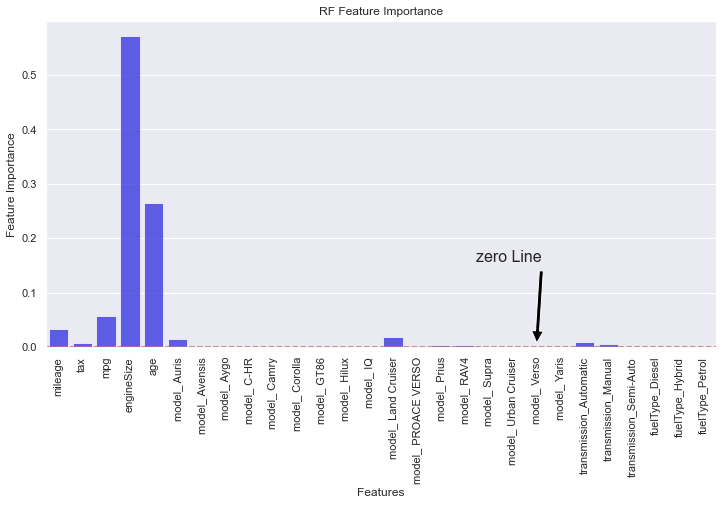

In [125]:
sns.set()
ax=plt.figure(figsize=(12,6))
ax=sns.barplot(x=features,y=fi_rf,palette=['blue'],alpha=0.7)
ax.set(title = "RF Feature Importance", xlabel = "Features", ylabel = "Feature Importance")
ax.set_xticklabels(features,rotation=90)
plt.axhline(y=0.0, color='r', linestyle='--')
ax.annotate('zero Line', (20, 0),
            xytext=(.74, 0.3), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=16,
            horizontalalignment='right', verticalalignment='top')


Text(0.11, 0.3, '45 ° line')

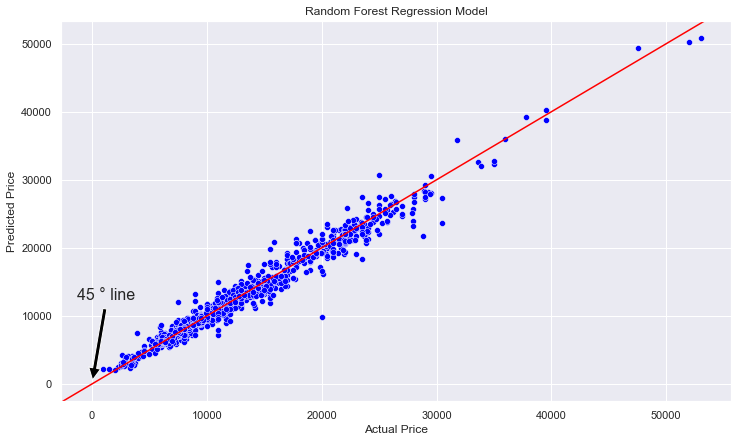

In [127]:
# need to write a function. but I do not have time
ax, fig= plt.subplots(figsize=(12,7))
ax = sns.scatterplot(y_test, y_pred_rf, color = 'blue')
ax.set(title = "Random Forest Regression Model", xlabel = "Actual Price", ylabel = "Predicted Price")
ax.axline([0, 0], [1, 1], color='red')
ax.annotate('45 \N{DEGREE SIGN} line', (1, 0),
            xytext=(0.11, 0.3), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=16,
            horizontalalignment='right', verticalalignment='top')

The plot looks much better than what we saw for linear regression. Undoubteley there are less error in the RF model

In [144]:
# Check if prediction is above 1500
z_rf= above_threshold(y_test,y_pred_rf)
z_rf

75

## XGBoost
XGBoost has many tuning parameters. We will first use some preset and default parameters to see how the model is doing .


In [132]:
xgr=xgb.XGBRegressor(random_state=1)
xgr.fit(X_train,y_train)
y_pred_xgr=xgr.predict(X_test)
xgr_score=xgr.score(X_test,y_test)
xgr_score

0.9713860758835275

Thats a really good score. We will not do any hyperparameter turing as I dont think we need a better score than this one.

In [134]:
fi_xgr=xgr.feature_importances_
fi_xgr

array([5.1085288e-03, 5.1706494e-03, 1.8115982e-02, 4.7937945e-01,
       1.1857622e-01, 5.8604404e-02, 1.5987830e-02, 4.8015276e-03,
       2.1790260e-02, 7.2240073e-04, 2.4649093e-03, 1.0590128e-03,
       1.9358699e-03, 4.3367101e-05, 1.2709931e-01, 6.7090914e-03,
       1.8790217e-02, 1.4399961e-02, 5.1388885e-03, 0.0000000e+00,
       1.1286535e-02, 2.8889808e-03, 2.4466800e-02, 3.8359266e-02,
       1.1632346e-03, 8.3747106e-03, 1.7526093e-03, 5.8101122e-03],
      dtype=float32)

Text(0.74, 0.3, 'zero Line')

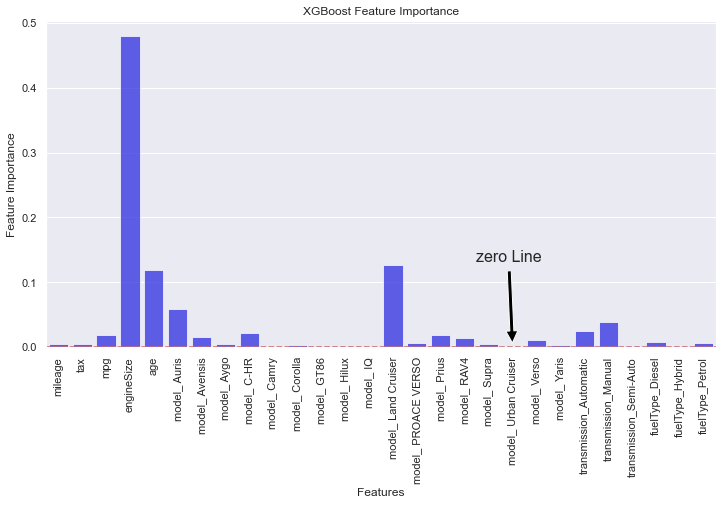

In [139]:
sns.set()
ax=plt.figure(figsize=(12,6))
ax=sns.barplot(x=features,y=fi_xgr,palette=['blue'],alpha=0.7)
ax.set(title = "XGBoost Feature Importance", xlabel = "Features", ylabel = "Feature Importance")
ax.set_xticklabels(features,rotation=90)
plt.axhline(y=0.0, color='r', linestyle='--')
ax.annotate('zero Line', (19, 0),
            xytext=(.74, 0.3), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=16,
            horizontalalignment='right', verticalalignment='top')


In [154]:
perf_grid_xgr=performance(y_test,y_pred_xgr)
perf_grid_xgr

{'R^2': 0.9713860758835275,
 'RMSE': 1043.6273086439528,
 'MAE': 722.6386337506665}

Pefromance is the best among thre three model we tested

Text(0.11, 0.3, '45 ° line')

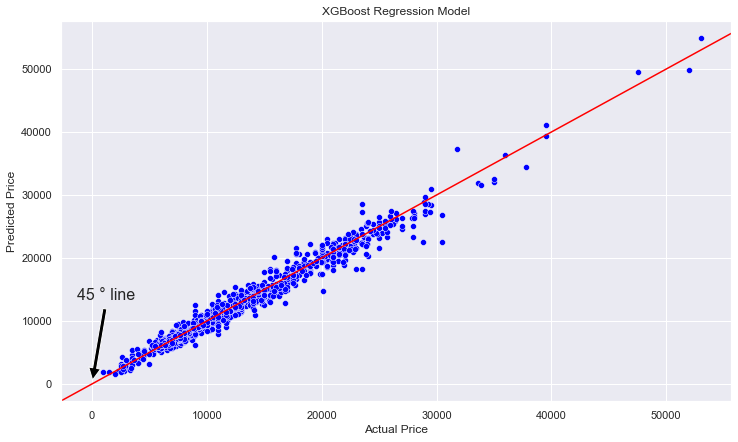

In [141]:
# need to write a function. but I do not have time
ax, fig= plt.subplots(figsize=(12,7))
ax = sns.scatterplot(y_test, y_pred_xgr, color = 'blue')
ax.set(title = "XGBoost Regression Model", xlabel = "Actual Price", ylabel = "Predicted Price")
ax.axline([0, 0], [1, 1], color='red')
ax.annotate('45 \N{DEGREE SIGN} line', (1, 0),
            xytext=(0.11, 0.3), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=16,
            horizontalalignment='right', verticalalignment='top')

In [150]:
# Check if prediction is above 1500
z_xgr= above_threshold(y_test,y_pred_xgr)
z_xgr

65

Only 65 prediction were above the 1500 threhshold, also R^2, RMSE, and RMA are best in XGBoost regression Model. 

For our current setup with features, we should use the XGBoost Regression for predicting price.
In the future, we need to fine-tune the XGBoosting and do some feature engineering (such as reducing the number of features) to improve the model.